In [4]:
import skimage as sk

In [5]:
import numpy as np 
from skimage.io import imread, imsave
from skimage.color import rgb2hsv, rgb2lab
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import os
import fnmatch
from tqdm import tqdm
from sklearn.metrics import pairwise_distances_argmin, pairwise_distances
import random
import skimage as sk

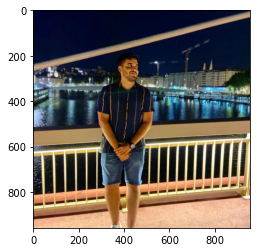

In [6]:
#im = imread("Namibia3.png")
#im = imread("Bob-Marley-toujours-un-bon-vendeur.jpg")
im = imread("maachou.jpg")
plt.imshow(im)

In [7]:
rescale_ratio = 1/15
rescaled = rescale(im, rescale_ratio, multichannel=True)
rescaled_h, rescaled_w = rescaled.shape[:-1]

label_row_size = 200
label_col_size = 200

n_rows = rescaled_h * label_row_size
n_columns =rescaled_w * label_col_size

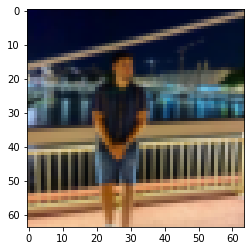

In [8]:
plt.imshow(rescaled)

In [9]:
def crop_center(im, new_width, new_height):
    height, width = im.shape[:-1]   # Get dimensions
    
    
    left = int((width - new_width)/2)
    top = int((height - new_height)/2)
    right = int((width + new_width)/2)
    bottom = int((height + new_height)/2)

    # Crop the center of the image
    im2 = im[top:bottom,left:right,:]
    return im2

In [11]:
imgs_dir = """C:\\Users\\TheMatrix\\Desktop\\AESTHETIC2\\Index of -i-03050 - 18-01-2022 20-22-27"""
def extract_mean(imgs_dir , crop_row,crop_column):
    im_paths = []
    means = []
    for file in os.listdir(imgs_dir):
        if fnmatch.fnmatch(file, "*.jpg") or fnmatch.fnmatch(file, "*.jpeg") or fnmatch.fnmatch(file, "*.png") :
            try:
                im_ = sk.img_as_ubyte(crop_center(imread(imgs_dir + "\\" + file)[:,:,:3], crop_row, crop_column))/255 
                if len(im_.shape) < 3 or im_.shape[0]<crop_row or  im_.shape[1]<crop_column : #small image or black and white
                    continue
                else:
                    im_paths.append(imgs_dir + "\\" + file)
                    mean = np.mean(rgb2lab(im_) , axis = (0,1))
                    means.append(mean)
            except: 
                continue
    means = np.array(means)
    return means,im_paths

means, im_paths = extract_mean(imgs_dir,label_row_size, label_col_size)

In [12]:
len(im_paths)

1696

In [13]:
means.shape

(1696, 3)

In [14]:
rescaled.shape

(64, 64, 3)

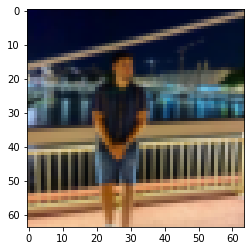

In [15]:
plt.imshow(rescaled)

In [16]:
rescaled = rgb2lab(rescaled)

In [17]:
rescaled.shape[:-1]

(64, 64)

In [18]:
pixels = np.reshape(rescaled,(rescaled_h*rescaled_w,3))

In [19]:
pixels.shape

(4096, 3)

In [20]:
distances = pairwise_distances(pixels, means)
labels = []
for i in range(len(pixels)):
    d_ = distances[i,:]
    indices = np.argsort(d_)[:10]
    labels.append(random.choice(indices))

In [21]:
labels = np.reshape(labels, (rescaled_h,rescaled_w))
labels.shape

(64, 64)

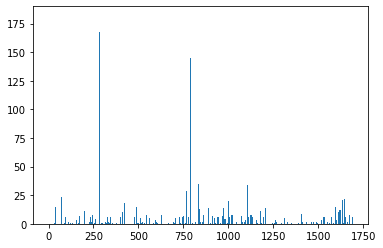

In [22]:
plt.hist(labels.flatten(), bins = 1000)
plt.show()

In [23]:
new_image = np.zeros((n_rows,n_columns,3), dtype = 'uint8')
for i in tqdm(range(rescaled_h)):
    for j in range(rescaled_w):
        label = labels[i,j]
        pth = im_paths[label]
        label_img = sk.img_as_ubyte(crop_center(imread(pth),label_col_size, label_row_size))
        try:
            new_image[i * label_row_size: (i+1) * label_row_size ,j * label_col_size: (j+1) * label_col_size, : ] = label_img
        except:
            continue

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 15.08it/s]


In [24]:
#imsave("kanye_west_cover2.jpeg",arr = new_image )

In [26]:
import cv2
save_im = cv2.resize(cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR) , (im.shape[1]*3, im.shape[0]*3))
cv2.imwrite("maachou_sex2.jpeg", save_im)

True